#  Este es un ejemplo de Pos Tagging  usando CRFs y un conjunto de características  importantes sobre la forma y posición de la palabra, el desempeño del clasificador es de 96%. El modelo CRF se entrenó sobre el corpus en español Conll2002.

# Dataset de conll2002  desde nltk

In [1]:
#importing all the needed libraries
import pandas as pd       
import nltk
import sklearn
import sklearn_crfsuite
import scipy.stats
import math, string, re

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from itertools import chain
from sklearn.preprocessing import MultiLabelBinarizer

# Se extraen los conjuntos de entrenamiento y de testeo sobre Conll2002


In [2]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
print(test_sents[4])

[('Los', 'DA', 'O'), ('clientes', 'NC', 'O'), ('pueden', 'VMI', 'O'), ('utilizar', 'VMN', 'O'), ('el', 'DA', 'O'), ('portal', 'NC', 'O'), ('"', 'Fe', 'O'), ('viajesydestinos.com', 'NC', 'B-MISC'), ('"', 'Fe', 'O'), (',', 'Fc', 'O'), ('que', 'PR', 'O'), ('el', 'DA', 'O'), ('pasado', 'AQ', 'O'), ('año', 'NC', 'O'), ('recibió', 'VMI', 'O'), ('ya', 'RG', 'O'), ('más', 'RG', 'O'), ('de', 'SP', 'O'), ('medio', 'DN', 'O'), ('millón', 'NC', 'O'), ('de', 'SP', 'O'), ('visitas', 'NC', 'O'), ('de', 'SP', 'O'), ('Internautas', 'NC', 'B-MISC'), (',', 'Fc', 'O'), ('para', 'SP', 'O'), ('consultar', 'VMN', 'O'), ('tarifas', 'NC', 'O'), ('de', 'SP', 'O'), ('billetes', 'NC', 'O'), ('de', 'SP', 'O'), ('transporte', 'NC', 'O'), (',', 'Fc', 'O'), ('plazas', 'NC', 'O'), ('hoteleras', 'AQ', 'O'), ('o', 'CC', 'O'), ('paquetes', 'NC', 'O'), ('turísticos', 'AQ', 'O'), (',', 'Fc', 'O'), ('aunque', 'CS', 'O'), ('la', 'DA', 'O'), ('venta', 'NC', 'O'), ('final', 'AQ', 'O'), ('corre', 'VMI', 'O'), ('siempre', 'RG', 

# Features o características  de la palabra

1. La palabra
2. La palabra en minúsculas
3. Prefijos y sufijos de la palabra de diferentes longitudes.
4. Si la palabra es un dígito
5. Si la palabra es un signo de puntuación
6. Si la palabra está al principio de la oración (BOS) o al final de la oración (EOS) o ninguna
7. La longitud de la palabra- no. de caracteres (ya que se espera que las palabras más cortas pertenezcan a un POS en particular, por ejemplo, preposiciones, pronombres)
8. Versión derivada de la palabra, que elimina todas las vocales junto con g, y, n del final de la palabra, pero deja al menos una raíz larga de 2 caracteres
9. Características mencionadas anteriormente para la palabra anterior, la palabra siguiente y las palabras dos lugares antes y después

In [3]:

#function to extract features
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word': word,
        'len(word)': len(word),
        'word[:4]': word[:4],
        'word[:3]': word[:3],
        'word[:2]': word[:2],
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-4:]': word[-4:],
        'word.lower()': word.lower(),
        'word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word.lower()),
        'word.ispunctuation': (word in string.punctuation),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word': word1,
            '-1:len(word)': len(word1),
            '-1:word.lower()': word1.lower(),
            '-1:word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word1.lower()),
            '-1:word[:3]': word1[:3],
            '-1:word[:2]': word1[:2],
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.ispunctuation': (word1 in string.punctuation),
        })

    else:
        features['BOS'] = True

    if i > 1:
        word2 = sent[i-2][0]
        features.update({
            '-2:word': word2,
            '-2:len(word)': len(word2),
            '-2:word.lower()': word2.lower(),
            '-2:word[:3]': word2[:3],
            '-2:word[:2]': word2[:2],
            '-2:word[-3:]': word2[-3:],
            '-2:word[-2:]': word2[-2:],
            '-2:word.isdigit()': word2.isdigit(),
            '-2:word.ispunctuation': (word2 in string.punctuation),
        })

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word': word1,
            '+1:len(word)': len(word1),
            '+1:word.lower()': word1.lower(),
            '+1:word[:3]': word1[:3],
            '+1:word[:2]': word1[:2],
            '+1:word[-3:]': word1[-3:],
            '+1:word[-2:]': word1[-2:],
            '+1:word.isdigit()': word1.isdigit(),
            '+1:word.ispunctuation': (word1 in string.punctuation),
        })

    else:
        features['EOS'] = True

    if i < len(sent) - 2:
        word2 = sent[i+2][0]
        features.update({
            '+2:word': word2,
            '+2:len(word)': len(word2),
            '+2:word.lower()': word2.lower(),
            '+2:word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word2.lower()),
            '+2:word[:3]': word2[:3],
            '+2:word[:2]': word2[:2],
            '+2:word[-3:]': word2[-3:],
            '+2:word[-2:]': word2[-2:],
            '+2:word.isdigit()': word2.isdigit(),
            '+2:word.ispunctuation': (word2 in string.punctuation),
        })

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [word[1] for word in sent]

def sent2tokens(sent):
    return [word[0] for word in sent]

In [4]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 2.8 s, sys: 195 ms, total: 3 s
Wall time: 3 s


In [5]:
X_train[0][2]

{'bias': 1.0,
 'word': 'Australia',
 'len(word)': 9,
 'word[:4]': 'Aust',
 'word[:3]': 'Aus',
 'word[:2]': 'Au',
 'word[-3:]': 'lia',
 'word[-2:]': 'ia',
 'word[-4:]': 'alia',
 'word.lower()': 'australia',
 'word.stemmed': 'austral',
 'word.ispunctuation': False,
 'word.isdigit()': False,
 '-1:word': '(',
 '-1:len(word)': 1,
 '-1:word.lower()': '(',
 '-1:word.stemmed': '(',
 '-1:word[:3]': '(',
 '-1:word[:2]': '(',
 '-1:word[-3:]': '(',
 '-1:word[-2:]': '(',
 '-1:word.isdigit()': False,
 '-1:word.ispunctuation': True,
 '-2:word': 'Melbourne',
 '-2:len(word)': 9,
 '-2:word.lower()': 'melbourne',
 '-2:word[:3]': 'Mel',
 '-2:word[:2]': 'Me',
 '-2:word[-3:]': 'rne',
 '-2:word[-2:]': 'ne',
 '-2:word.isdigit()': False,
 '-2:word.ispunctuation': False,
 '+1:word': ')',
 '+1:len(word)': 1,
 '+1:word.lower()': ')',
 '+1:word[:3]': ')',
 '+1:word[:2]': ')',
 '+1:word[-3:]': ')',
 '+1:word[-2:]': ')',
 '+1:word.isdigit()': False,
 '+1:word.ispunctuation': True,
 '+2:word': ',',
 '+2:len(word)': 1

# Usamos un clasificador de CRFs llamado crfsuite, se definen un conjunto de parámetros que formalmente tiene que ver con la activación de las funciones de características para las condicionalidades y se entrena el conjunto (X_train, y_train) de conll2002. El algoritmo en el cual se basa CRF es el lbfgs, este sigue siendo un modelo Log-Linear donde las condicionalidades dependende de las funciones de características. Por ejemplo, f(y_i-1, y_i, x_i,i), ponen en juego en la palabra i, los antecedentes del condicional y_i-1 y x_i para condicionar a y_i. Por ejemplo, en una instanciación se quiere predecir la etiqueta de la palabra x_i=Australia, pero tenemos como antecedentes condicionales y_i-1=NP y x_i-1=Melbourne entonces el modelo debería predecir que y_i=NP.

In [6]:
                                
crf = sklearn_crfsuite.CRF(
    algorithm = 'lbfgs',
    c1 = 0.25,
    c2 = 0.3,
    max_iterations = 100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train) 

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.25, c2=0.3,
    keep_tempfiles=None, max_iterations=100)

# Esta sentencia de testeo debe ser preprocesada con las features  de cada palabra para una sentencia

In [7]:
print(test_sents[0])
print(X_test[0])

[('La', 'DA', 'B-LOC'), ('Coruña', 'NC', 'I-LOC'), (',', 'Fc', 'O'), ('23', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFECOM', 'NP', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]
[{'bias': 1.0, 'word': 'La', 'len(word)': 2, 'word[:4]': 'La', 'word[:3]': 'La', 'word[:2]': 'La', 'word[-3:]': 'La', 'word[-2:]': 'La', 'word[-4:]': 'La', 'word.lower()': 'la', 'word.stemmed': 'la', 'word.ispunctuation': False, 'word.isdigit()': False, 'BOS': True, '+1:word': 'Coruña', '+1:len(word)': 6, '+1:word.lower()': 'coruña', '+1:word[:3]': 'Cor', '+1:word[:2]': 'Co', '+1:word[-3:]': 'uña', '+1:word[-2:]': 'ña', '+1:word.isdigit()': False, '+1:word.ispunctuation': False, '+2:word': ',', '+2:len(word)': 1, '+2:word.lower()': ',', '+2:word.stemmed': ',', '+2:word[:3]': ',', '+2:word[:2]': ',', '+2:word[-3:]': ',', '+2:word[-2:]': ',', '+2:word.isdigit()': False, '+2:word.ispunctuation': True}, {'bias': 1.0, 'word': 'Coruña', 'len(word)': 6, 'word[:4]': 'Coru', 'word[:3]': 'Cor', 'word[:2]': 'C

In [8]:
labels = list(crf.classes_)
labels

['NP',
 'Fpa',
 'Fpt',
 'Fc',
 'Z',
 'NC',
 'Fp',
 'Fg',
 'DA',
 'AQ',
 'SP',
 'VMI',
 'RG',
 'VMN',
 'DI',
 'PR',
 'CS',
 'P0',
 'VMS',
 'CC',
 'PP',
 'VAN',
 'VMP',
 'DD',
 'VAI',
 'VSP',
 'PN',
 'VMM',
 'DP',
 'RN',
 'PI',
 'VSI',
 'VSS',
 'VMG',
 'Fe',
 'DN',
 'AO',
 'Fz',
 'Fd',
 'Fx',
 'I',
 'VSN',
 'PD',
 'Fs',
 'PT',
 'VAS',
 'Fia',
 'Fit',
 'Fh',
 'VSG',
 'PX',
 'VAP',
 'DT',
 'Y',
 'Fat',
 'VSM',
 'Faa',
 'Ft',
 'VAM']

# Evaluación de desempeño

En esta parte se mide el desempeño del clasificador CRF. Entonces se debe comparar el y_test que es el conjunto de etiquetas de testeo que fue escoguido inicialmente del corpus conll2002, con el y_pred que es el etiquetado del conjunto de testeo X_test, (después de generado el modelo) de esa forma se comparan todas las etiquetas; las del conjunto de testeo y las predichas. La medida de desempeño se fundamenta en la matriz de confusión. Los tp son los verdaderos positivos, los tp son los verdaderos positivos, los tn son los verdaderos negativos, estos son prediciones correctas sobre los valores actuales. La precision son los tp sobre los resultados actuales (Actual-gold) y el recall son los tp sobre los resultados predichos. F1 o F-score es una media armónica de la precision y el recall. Un fp, se da cuando una palabra anotada como pronombre (Actual-gold) es clasificada como verbo, entonces se puede mirar la precisión del clasificador con respecto al verbo, si tiene un tp=5, entonces p=5/6=0.83, es decir, el clasificador anota los verbos con una precisión del 83% y así se puede revisar el recall a través del fn.

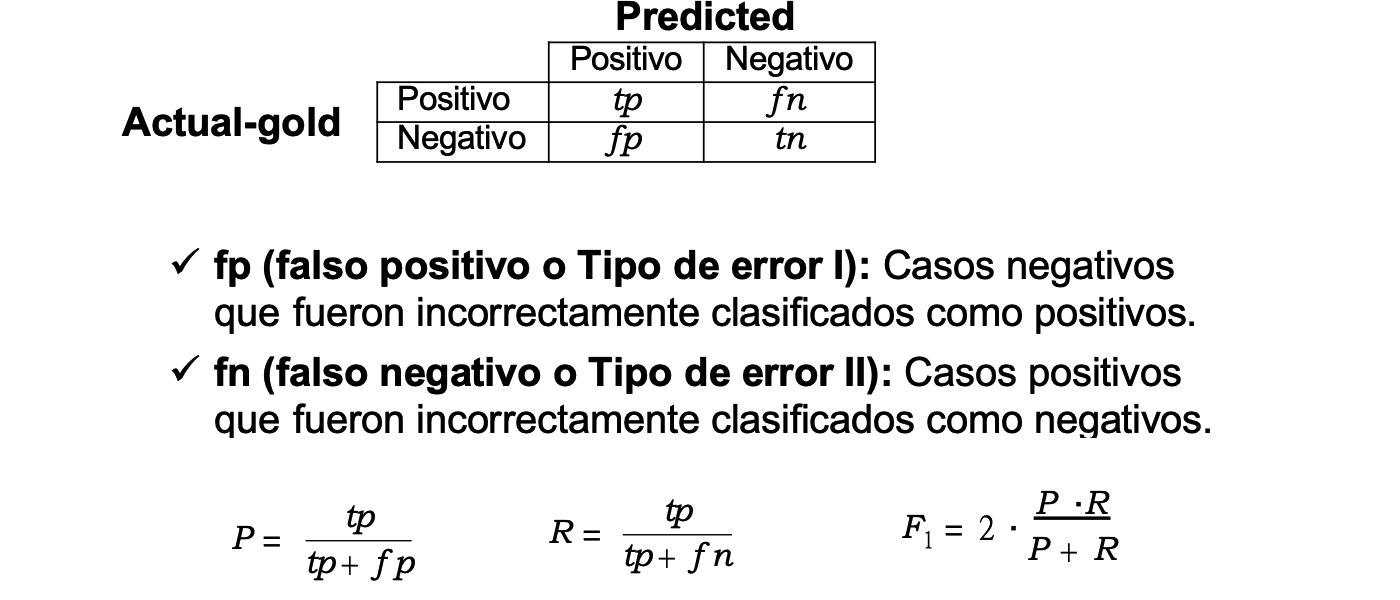

In [9]:

from IPython.display import Image
Image(filename='mt-1.png')

In [10]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


0.9649182740094661

In [11]:
#obtaining metrics such as accuracy, etc. on the test set
ypred = crf.predict(X_test)
print('F1 score on the test set = {}\n'.format(metrics.flat_f1_score(y_test, y_pred,
average='weighted', labels=labels)))
print('Accuracy on the test set = {}\n'.format(metrics.flat_accuracy_score(y_test, y_pred)))

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print('Test set classification report: \n\n{}'.format(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3)))

F1 score on the test set = 0.9649182740094661

Accuracy on the test set = 0.9654396212135913



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['I', 'Y', 'Z', 'P0', 'DA', 'VAI', 'VAM', 'VAN', 'VAP', 'VAS', 'CC', 'NC', 'DD', 'PD', 'RG', 'DI', 'PI', 'VMG', 'VMI', 'VMM', 'VMN', 'VMP', 'VMS', 'DN', 'PN', 'RN', 'AO', 'DP', 'NP', 'PP', 'SP', 'AQ', 'PR', 'CS', 'VSG', 'VSI', 'VSM', 'VSN', 'VSP', 'VSS', 'DT', 'PT', 'PX', 'Faa', 'Fat', 'Fc', 'Fd', 'Fe', 'Fg', 'Fh', 'Fia', 'Fit', 'Fp', 'Fpa', 'Fpt', 'Fs', 'Ft', 'Fx', 'Fz'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning

Test set classification report: 

              precision    recall  f1-score   support

           I      1.000     0.783     0.878        23
           Y      0.000     0.000     0.000         3
           Z      0.942     0.939     0.941      1080
          P0      1.000     1.000     1.000       532
          DA      0.998     0.999     0.999      5034
         VAI      1.000     1.000     1.000       299
         VAM      0.000     0.000     0.000         0
         VAN      1.000     1.000     1.000        19
         VAP      1.000     1.000     1.000         1
         VAS      1.000     1.000     1.000        26
          CC      1.000     1.000     1.000      1198
          NC      0.942     0.960     0.951     12347
          DD      0.984     0.997     0.990       364
          PD      0.960     0.750     0.842        32
          RG      0.974     0.971     0.972      1037
          DI      0.984     0.989     0.986      1090
          PI      0.990     0.884     0.934    

# Predicción de una entrada cualquiera que no se encuentra en el conjunto de testeo

Para preprocesar una entrada cualquiera de prueba, esta debe estar en  el mismo formato en el que vienen los conjuntos  entrenamiento y de testeo.  Por lo tanto, como el problema de Pos Tagging es un problema de  etiquetado secuencial donde la  secuencia de palabras es preprocesada  y para cada palabra se definen el conjunto de características de forma y ubicación a través de la función  word2features y finalmente se clasifica cada una de las categoría de la sentencia de entrada. 

In [12]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
 
prueba=[('La',''), ('Coruña',''), ('sería',''), ('el',''), ('nuevo',''), ('equipo',''), ('de',''), ('James',''), 
        ('Rodriguez',''), (',',''), ('aunque',''), ('todavía',''), ('es',''), ('del',''),  ('Real',''),
        ('Madrid',''), ('de',''), ('España','')]
def pos_tag(sentence):
    sentence_features = [word2features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, crf.predict([sentence_features])[0]))
#print(sentence_features) 
print(pos_tag(prueba))  # [('I', 'PRP'), ('am', 'VBP'), ('Bob', 'NNP'), ('!', '.')]

[(('La', ''), 'DA'), (('Coruña', ''), 'NC'), (('sería', ''), 'VSI'), (('el', ''), 'DA'), (('nuevo', ''), 'AQ'), (('equipo', ''), 'NC'), (('de', ''), 'SP'), (('James', ''), 'VMS'), (('Rodriguez', ''), 'NC'), ((',', ''), 'Fc'), (('aunque', ''), 'CS'), (('todavía', ''), 'RG'), (('es', ''), 'VSI'), (('del', ''), 'SP'), (('Real', ''), 'AQ'), (('Madrid', ''), 'NC'), (('de', ''), 'SP'), (('España', ''), 'NC')]
